In [ ]:
import requests
from bs4 import BeautifulSoup
import re
import numpy as np


years = list(range(1980, 2022))  # 1980~2021년에 걸쳐서 세계 바둑 랭킹자료를 가져온다.
                                 # YYYY년 01월 01일의 랭킹을 가져올 것이다. 

total_players_country = []       # 연도/선수별 국가를 담을 list
total_players_age = []           # 연도/선수별 나이(만)를 담을 list
total_players_elo_point = []     # 연도/선수별 랭킹 포인트(ELO)를 담을 list
total_var = []                   # 연도별 랭킹 포인트의 분산을 담을 list

# =========================================================================================================
# 연도별 자료를 가져올 for문
for year in range(len(years)):
    print(years[year])
    
    # url 설정
    url = 'https://www.goratings.org/en/history/' + str(years[year])+ '-01-01.html'
    # 사이트 주소의 마지막 부분이 /YYYY-01-01.html 이므로 for문을 통해 연도별 url을 부른다. 
    
    # html
    html = requests.get(url).text
    bs = BeautifulSoup(html, 'html.parser')
    
    # 데이터 가져오기 
    data = []                    # html에서 필요한 정보가 한꺼번에 있는 구절을 아예 통으로 불러올 list
    players_num = []             # 바둑기사의 고유번호를 넣을 list
                                 # gorating.org 사이트에서는 바둑 기사마다 고유번호를 부여해서 관리한다.
                                 # 가령, 이세돌 9단은 5번이고, 이창호 9단은 18번이다.
                                 # 'https://www.goratings.org/en/players/'에서 마지막에 고유번호를 넣으면
                                 # 바둑기사별 개인정보를 볼 수 있는 새로운 화면이 생긴다. 
    players_country = []         # 바둑 기사별 소속 국가를 넣을 list
    players_age = []             # 바둑 기사의 당시 연도의 나이(만)을 담을 list
    players_rank = []            # 바둑 기사의 당시 연도의 랭킹을 담을 list
    players_elo_point = []       # 바둑 기사의 당시 연도의 랭킹 포인트(ELO)를 담을 list
    
    # ----------------------------------------------------------------------------------------------------
    # 해당 연도의 선수별 자료를 가져올 for문
    # 우리는 연도별로 1위~20위의 선수 정보를 가져올 것이다. 
    for i in range(20):
        print(i)
        
        ## html의 필요한 정보가 있는 구절 
        #-> tr태그를 통해 구분된다. 
        data.append(str(bs.select('tr')[i+1]))  
        # bs.select('tr')[i]가 i위인 기사인데 랭킹은 1위부터 시작하니 i+1로 한다.
        
        ## 바둑기사의 고유번호 
        #-> players/와 .html이라는 단어 사이에 위치한다. 
        players_num.append(str(re.search('players/(.+?).html',data[i]).group(1)))
        
        ## 바둑기사의 소속 국가 
        #-> flags와 .svg라는 단어 사이에 위치한다. 
        players_country.append(str(re.search('flags/(.+?).svg',data[i]).group(1)))
        
        ## 바둑기사의 랭킹 포인트(ELO) 
        #-> middle"/></td><td>과 </td>\n</tr>라는 단어 사이에 위치한다. 
        players_elo_point.append(float(re.search('middle"/></td><td>(.+?)</td>\n</tr>',data[i]).group(1)))
        
        ## 바둑기사의 랭킹
        #-> tr태그의 하위 태그인 td태그 중 이름이 r인 것을 통해 구분된다. 
        players_rank.append(float(bs.select('tr>td.r')[i].text))
        
        
        ### 바둑기사의 나이 구하기 
        # 바둑기사의 나이는 우리가 기사의 개인정보에 있는 생년월일을 통해 직접 계산해야한다. 
        # 먼저 바둑기사의 개인정보를 가져올 수 있는 url을 불러온다.
        # 바둑기사의 고유번호를 이용하면 된다. 
        player_url = 'https://www.goratings.org/en/players/' + str(players_num[i]) + '.html'
        player_html = requests.get(player_url).text
        player_bs = BeautifulSoup(player_html, 'html.parser')
        
        ## 바둑기사의 생년월일
        #-> tr태그의 하위 태그면서 이름이 r인 td태그 중에 제일 마지막이 생년월일이다. 
        player_birthday = player_bs.select('tr>td.r')[-1].text
        
        ## 바둑기사의 나이
        #-> 해당 연도에서 바둑기사의 출생연도를 빼준다. 
        # 출생 연도는 생년월일의 맨 앞의 4글자이므로 이 부분만 가져와서 계산한다. 
        players_age.append(years[year] - float(player_birthday[:4]))
    # -----------------------------------------------------------------------------------------------------
    
    ## 다시 연도별 for문으로 돌아와서
    total_players_elo_point.append(players_elo_point) # 연도별 바둑 기사의 랭킹 포인트 차례차례 추가  
    total_var.append(np.var(players_elo_point))       # 연도별 랭킹 포인트 분산 차례차례 추가
    total_players_country.append(players_country)     # 연도별 바둑 기사의 소속국가 차례차례 추가
    total_players_age.append(players_age)             # 연도별 바둑 기사의 나이(만) 차례차례 추가
    
# ===========================================================================================================

In [10]:
import csv

## csv 파일에 데이터 저장

f = open('world_baduk.csv', 'w')

for year in range(len(years)):
    f.write(str(years[year]) + '년' + '\n')                       # 연도
    f.write('국가' + ',' + '나이' + ',' + '포인트' + '\n')        # headerlines : 국가, 나이, 랭킹포인트
    for player in range(20):
        f.write(str(total_players_country[year][player]) + ',')   
        f.write(str(total_players_age[year][player]) + ',')
        f.write(str(total_players_elo_point[year][player]) + '\n')
    f.write('분산:' + str(total_var[year]) + '\n' + '\n')         # 마지막 줄에 랭킹 포인트의 분산


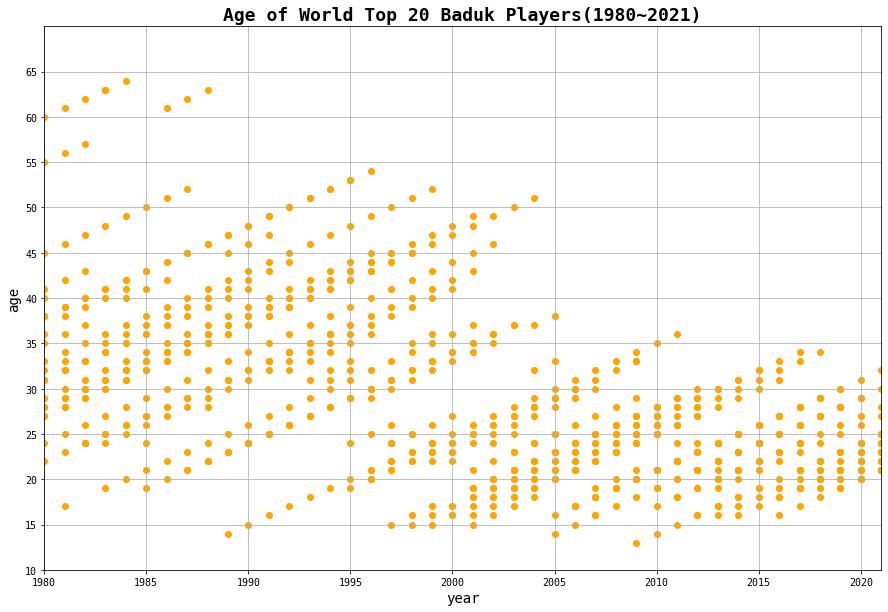

In [9]:
import matplotlib.pyplot as plt
import numpy as np

## 연도별 TOP20 바둑기사의 나이 변화를 보기 위한 PLOT

plt.figure(figsize=(15,10))                         # plot의 크기 설정
plt.rcParams.update({'font.family':'monospace'})    # plot의 글씨체 폰트 설정

# 연도별, 기사별로 하나씩 점을 찍어나간다. 
for year in range(len(years)):
    for player in range(20):
        plt.scatter(years[year], total_players_age[year][player], c = 'orange') # 분산형 plot 오렌지색으로 설정
            

ax = plt.gca() 
ax.set_facecolor('w')   # plot의 기본 배경 색깔을 흰색으로 설정

plt.xlim(1980, 2021)    # plot의 x축 범위
plt.ylim(10, 70)        # plot의 y축 범위

plt.xlabel('year', fontsize = 14)         # plot의 x축 label설정, 글씨 크기는 14  
plt.ylabel('age', fontsize = 14)          # plot의 y축 label설정, 글씨 크기는 14 
ax.set_xticks(np.arange(1980, 2021, 5))   # plot의 x축 간격 조정 -> 5년 간격
ax.set_yticks(np.arange(10, 70, 5))       # plot의 y축 간격 조정 -> 5세 간격
ax.grid(True)      # 그리드 켜기

plt.title('Age of World Top 20 Baduk Players(1980~2021)', fontsize = 18, fontweight = 'bold')
plt.show()
    

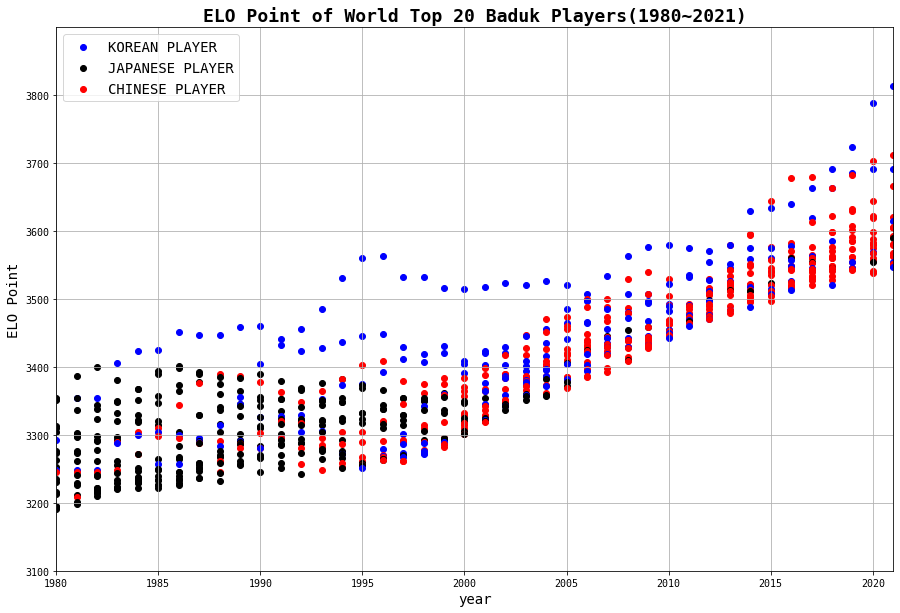

In [24]:
import matplotlib.pyplot as plt
import numpy as np

## 연도별 TOP20 바둑기사의 랭킹 포인트(ELO) 변화를 보기 위한 PLOT

plt.figure(figsize=(15,10))                         # plot의 크기 설정
plt.rcParams.update({'font.family':'monospace'});   # plot의 글씨체 폰트 설정

# 연도별, 기사별로 하나씩 점을 찍어나간다.
for year in range(len(years)):
    for player in range(20):
        
        # 만약 그 기사가 한국소속이라면 kr이라고 표시되므로 이를 골라 파란색으로 점을 찍는다. 
        if total_players_country[year][player] == 'kr':
            kr = plt.scatter(years[year], total_players_elo_point[year][player], c = 'blue', label = 'KOREA')
        
        # 만약 그 기사가 일본소속이라면 jp이라고 표시되므로 이를 골라 검정색으로 점을 찍는다.
        elif total_players_country[year][player] == 'jp':
            jp = plt.scatter(years[year], total_players_elo_point[year][player], c = 'black', label = 'JAPAN')
            
        # 만약 그 기사가 중국소속이라면 cn이라고 표시되므로 이를 골라 빨간색으로 점을 찍는다.
        elif total_players_country[year][player] == 'cn':
            cn = plt.scatter(years[year], total_players_elo_point[year][player], c = 'red', label = 'CHINA')
            

ax = plt.gca() 
ax.set_facecolor('w')   # plot의 기본 배경 색깔을 흰색으로 설정

plt.xlim(1980, 2021)    # plot의 x축 범위
plt.ylim(3100, 3900)    # plot의 y축 범위

plt.xlabel('year', fontsize = 14)             # plot의 x축 label설정, 글씨 크기는 14
plt.ylabel('ELO Point', fontsize = 14)        # plot의 y축 label설정, 글씨 크기는 14 
ax.set_xticks(np.arange(1980, 2021, 5))       # plot의 x축 간격 조정 -> 5년 간격
ax.set_yticks(np.arange(3100, 3900, 100))     # plot의 y축 간격 조정 -> 100점 간격
ax.grid(True)      # 그리드 켜기

# 범례 추가하기
ax.legend([kr, jp, cn], ['KOREAN PLAYER', 'JAPANESE PLAYER', 'CHINESE PLAYER'], loc = 'upper left', fontsize = 14)

plt.title('ELO Point of World Top 20 Baduk Players(1980~2021)', fontsize = 18, fontweight = 'bold')
plt.show()


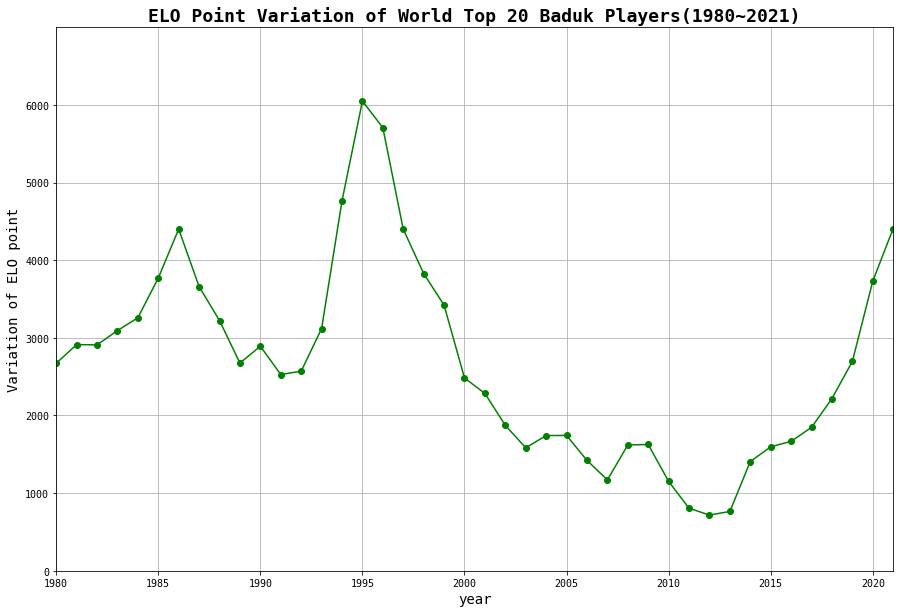

In [35]:
import matplotlib.pyplot as plt
import numpy as np

## 연도별 TOP20 바둑기사의 랭킹 포인트(ELO) 분산 변화를 보기 위한 PLOT

plt.figure(figsize=(15,10))                         # plot의 크기 설정
plt.rcParams.update({'font.family':'monospace'})    # plot의 글씨체 폰트 설정

plt.plot(years, total_var, color = 'green', marker = 'o')   # x축은 연도, y축은 분산, 초록색 마커를 가진 plot
        
ax = plt.gca()
ax.set_facecolor('w')

plt.xlim(1980, 2021) 
plt.ylim(0, 7000)

plt.xlabel('year', fontsize = 14) 
plt.ylabel('Variation of ELO point', fontsize = 14)
ax.set_xticks(np.arange(1980, 2021, 5))
ax.set_yticks(np.arange(0, 7000, 1000))
ax.grid(True)

plt.title('ELO Point Variation of World Top 20 Baduk Players(1980~2021)', fontsize = 18, fontweight = 'bold')
plt.show()